# Tests retrieval capacity in our knowledge base

Inspired by: https://huggingface.co/learn/cookbook/advanced_ragv

## Imports

In [ ]:
!pip install -q torch transformers accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl pacmap datasets langchain-community matplotlib ipywidgets plotly nbformat


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt
import glob
import json
import os
from langchain.docstore.document import Document as LangchainDocument
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

pd.set_option("display.max_colwidth", None)  # This will be helpful when visualizing retriever outputs

## Load our knowledge base

In [2]:
# Define data folder
data_folder = "../outputs/"

### Official legal publication

We add to our context:
- EPC_guidelines
- EPC Articles and Rules
- PCT Articles and Rules
- Case Laws

In [6]:
# Load all CSV
csv_files = glob.glob(f"{data_folder}/*.csv")
df_list = [pd.read_csv(file) for file in csv_files]
df = pd.concat(df_list, ignore_index=True) if df_list else pd.DataFrame(columns=["ref", "url", "content"])

# List of documents for LangChain
csv_documents = [
    LangchainDocument(page_content=row["content"], metadata={"ref": row["ref"], "url": row["url"]})
    for _, row in tqdm(df.iterrows(), total=len(df))
]

  0%|          | 0/4275 [00:00<?, ?it/s]

In [7]:
# To visualize
# csv_documents

### Solutions to exam questions

In [18]:
# Load JSON with "solution" in their name
json_files = glob.glob(f"{data_folder}/*solution*.json")

json_documents = []
for file in json_files:
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    # Extract justification and create Langchain documents
    filename = os.path.basename(file)  # Nom du fichier sans le chemin

    # Si le fichier contient "open" dans son nom, on récupère tout
    if "open" in filename:
        for key, entry in data.items():
            json_documents.append(
                LangchainDocument(
                    page_content=entry,
                    metadata={"ref": filename}
                )
            )
        
    else:
        for key, entry in data.items():
            if "Justification" in entry:
                json_documents.append(
                    LangchainDocument(
                        page_content=entry["Justification"],
                        metadata={"ref": filename}  # ref = Nom du fichier
                    )
                )

In [23]:
# To visualize
# json_documents

### Fusion of our knowledge

In [20]:
# Fusionner les données des CSV et JSON
RAW_KNOWLEDGE_BASE = csv_documents + json_documents

print(f"Total of documents loading : {len(RAW_KNOWLEDGE_BASE)}")

Total of documents loading : 4341


## Split documents into chunck

  0%|          | 0/6883 [00:00<?, ?it/s]

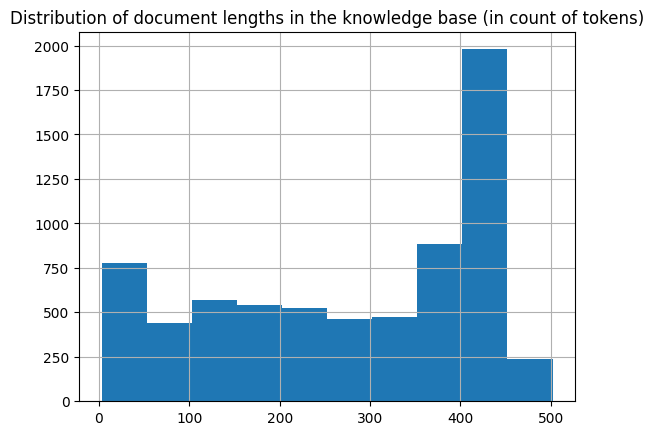

In [21]:
EMBEDDING_MODEL_NAME = "thenlper/gte-small"

MARKDOWN_SEPARATORS = [
    "\n\n",
    "\n",
    ".",
    " ",
    "",
]

def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

## Building the vector database

In [ ]:
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cpu"},  # replace 'cpu' by 'cuda' if you have Nvidia gpu
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

In [25]:
# Compute embeddings (can take time ~7min on my laptop)
KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

In [26]:
# Save embeddings
KNOWLEDGE_VECTOR_DATABASE.save_local("../outputs/rag_embeddings_thenlper_gte-small")

In [ ]:
# Load embeddings
KNOWLEDGE_VECTOR_DATABASE = FAISS.load_local("../outputs/rag_embeddings_thenlper_gte-small", embedding_model, allow_dangerous_deserialization=True)

## Embeddings vizualisation

Not implemented yet.

## Try Retrieval

In [5]:
# Load embeddings

EMBEDDING_MODEL_NAME = "thenlper/gte-small"

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cpu"},  # replace 'cpu' by 'cuda' if you have Nvidia gpu
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)


KNOWLEDGE_VECTOR_DATABASE = FAISS.load_local("../outputs/rag_embeddings_thenlper_gte-small", embedding_model, allow_dangerous_deserialization=True)

/tmp/ipykernel_738197/628335862.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


In [7]:
user_query = """Your Client, A Inc, is a sub-licensee under European patent application EP-1. Can the sub-licence be recorded in the European Patent Register?
 
A    No, it is not possible to record sub-licences in the European Patent Register.
 
B    Yes, any sub-licence can be recorded in the European Patent Register.
 
C    Yes, provided the licensee granting the sub-licence has recorded its licence in the European Patent Register.
"""

# Correct answer
"""
The correct answer is C.
 
A sub-licence can only be recorded in the European Patent Register if it is granted by a licensee whose licence is recorded in 
the Register (Rule 24(b) EPC, implementing Article 73 EPC).
"""

'\nThe correct answer is C.\n\nA sub-licence can only be recorded in the European Patent Register if it is granted by a licensee whose licence is recorded in \nthe Register (Rule 24(b) EPC, implementing Article 73 EPC).\n'

In [29]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print("\n========================== Retrieved Documents ==========================")
for i, doc in enumerate(retrieved_docs, start=1):
    print(f"\n========================== Document {i} ==========================")
    # print(doc.page_content)
    print("\n========================== Metadata ==========================")
    print(doc.metadata)


Starting retrieval for user_query='Your Client, A Inc, is a sub-licensee under European patent application EP-1. Can the sub-licence be recorded in the European Patent Register?\n\nA    No, it is not possible to record sub-licences in the European Patent Register.\n\nB    Yes, any sub-licence can be recorded in the European Patent Register.\n\nC    Yes, provided the licensee granting the sub-licence has recorded its licence in the European Patent Register.\n'...

========================== Retrieved Documents ==========================

========================== Document 1 ==========================

========================== Metadata ==========================
{'ref': 'EPC Rule 24', 'url': 'https://www.epo.org/en/legal/epc/2020/r24.html', 'start_index': 0}

========================== Document 2 ==========================

========================== Metadata ==========================
{'ref': 'Guidelines for Examination in the EPO, E-XIV, 6.1', 'url': 'https://www.epo.org/en/legal/g